In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller # 单位根检验
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.graphics.api import qqplot  # 画残差图
import statsmodels.tsa.stattools as st  # 参数选择函数
import statsmodels.api as sm # 白噪声检验 sm.stats.durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox  #白噪声检验

from itertools import product
from datetime import datetime


import warnings
warnings.filterwarnings('ignore')

In [139]:
plt.rcParams['font.family'] = ['Arial Unicode MS'] 

In [140]:
data = pd.read_csv("/Users/Yasmine/Desktop/GeekTime/数据分析45讲/项目/bitcoin-master/bitcoin_2012-01-01_to_2018-10-31.csv")

# 1. EDA

In [15]:
data.shape

(2497, 8)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2497 entries, 0 to 2496
Data columns (total 8 columns):
Timestamp            2497 non-null object
Open                 2494 non-null float64
High                 2494 non-null float64
Low                  2494 non-null float64
Close                2494 non-null float64
Volume_(BTC)         2494 non-null float64
Volume_(Currency)    2494 non-null float64
Weighted_Price       2494 non-null float64
dtypes: float64(7), object(1)
memory usage: 156.1+ KB


In [17]:
data.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000
mean,1796.769089,1798.233023,1795.108762,1796.753050,11.857845,16438.813010,1796.655279
std,3168.776266,3172.012067,3165.033337,3168.745873,9.572112,36571.399441,3168.522838
min,4.331667,4.331667,4.331667,4.331667,0.250000,1.227500,4.331667
25%,127.623257,127.661785,127.553212,127.604617,5.611589,1197.203060,127.614824
50%,435.514724,435.979699,435.034000,435.547107,9.137289,3309.633872,435.495644
75%,1033.162198,1034.051892,1032.682789,1033.242494,15.493902,11671.187070,1033.162668
max,19189.771080,19204.559310,19167.362650,19190.340630,119.522868,539960.154300,19186.169610


In [29]:
data['Timestamp'] = pd.to_datetime(data.Timestamp)

In [30]:
df = data[['Weighted_Price']].set_index(data.Timestamp)

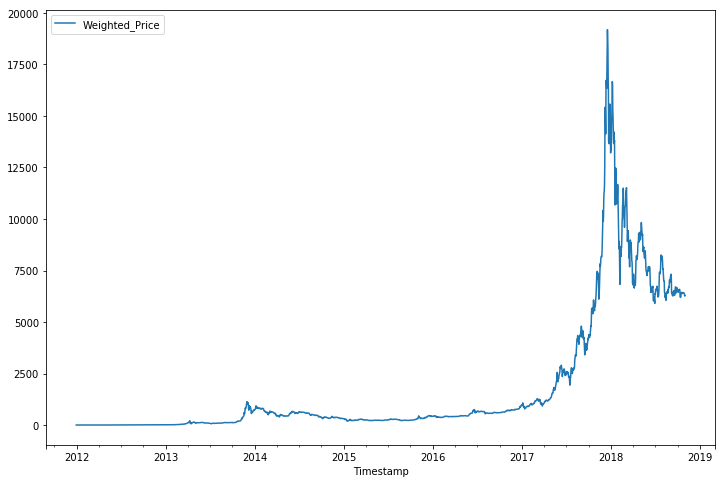

In [31]:
df.plot(figsize=(12,8))

In [154]:
df.dropna(how='any', inplace=True)

In [159]:
# 单位根检验
def adfuller_test(array):
    t = adfuller(array)  # ADF检验
    output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
    output['value']['Test Statistic Value'] = t[0]
    output['value']['p-value'] = t[1]
    output['value']['Lags Used'] = t[2]
    output['value']['Number of Observations Used'] = t[3]
    output['value']['Critical Value(1%)'] = t[4]['1%']
    output['value']['Critical Value(5%)'] = t[4]['5%']
    output['value']['Critical Value(10%)'] = t[4]['10%']
    print(output)

In [160]:
adfuller_test(df.Weighted_Price)

                                value
Test Statistic Value         -1.59229
p-value                      0.487466
Lags Used                          27
Number of Observations Used      2466
Critical Value(1%)             -3.433
Critical Value(5%)           -2.86271
Critical Value(10%)          -2.56739


In [162]:
# 一阶差分是平稳的，应该选用ARIMA(p, 1, q)
adfuller_test(df.Weighted_Price.diff(1).dropna())

                                   value
Test Statistic Value             -9.3015
p-value                      1.10933e-15
Lags Used                             27
Number of Observations Used         2465
Critical Value(1%)              -3.43301
Critical Value(5%)              -2.86271
Critical Value(10%)             -2.56739


In [163]:
# 按不同时间粒度聚合
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
df_week = df.resample('W').mean()

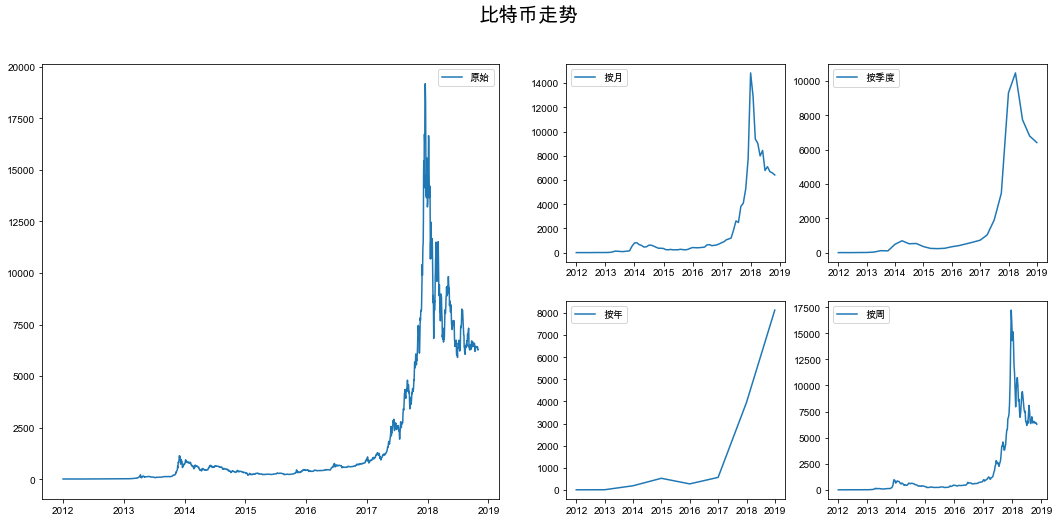

In [164]:
plt.figure(figsize=(18,8))
plt.suptitle('比特币走势', fontsize=20)
plt.subplot(243)
plt.plot(df_month.Weighted_Price, '-', label='按月')
plt.legend()
plt.subplot(244)
plt.plot(df_Q.Weighted_Price, '-', label='按季度')
plt.legend()
plt.subplot(247)
plt.plot(df_year.Weighted_Price, '-', label='按年')
plt.legend()
plt.subplot(248)
plt.plot(df_week.Weighted_Price, '-', label='按周')
plt.legend()
plt.subplot(121)
plt.plot(df.Weighted_Price, '-', label='原始')
plt.legend()
plt.show()

In [166]:
# 再检验df_month粒度
adfuller_test(df_month.Weighted_Price.diff(1).dropna())

                                   value
Test Statistic Value            -6.76145
p-value                      2.78552e-09
Lags Used                              1
Number of Observations Used           80
Critical Value(1%)              -3.51487
Critical Value(5%)              -2.89841
Critical Value(10%)             -2.58644


In [214]:
# 白噪声检验
acorr_ljungbox(df_month.Weighted_Price.diff(1).dropna(), lags=40)[1]
# 不是白噪声

array([0.11180528, 0.11562871, 0.16907836, 0.27609735, 0.4023365 ,
       0.40919998, 0.51302085, 0.52030808, 0.60361188, 0.65324564,
       0.73518344, 0.79928247, 0.85371516, 0.89655241, 0.92866963,
       0.95171968, 0.96857742, 0.97966295, 0.98732833, 0.99224872,
       0.99537431, 0.99729925, 0.99845681, 0.9991321 , 0.99952062,
       0.99973915, 0.99985951, 0.99992582, 0.99996182, 0.99998063,
       0.99999026, 0.99999516, 0.99999765, 0.99999886, 0.99999943,
       0.99999974, 0.99999988, 0.99999994, 0.99999997, 0.99999999])

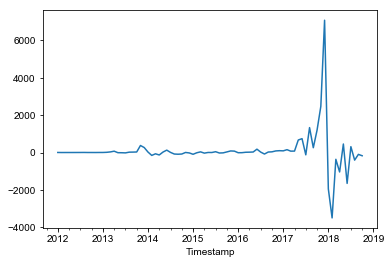

In [234]:
df_month.Weighted_Price.diff(1).dropna().plot()

# 2. 建模

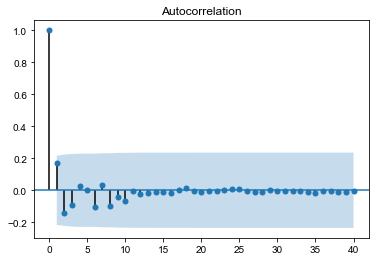

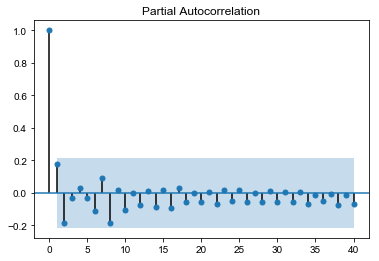

In [169]:
# 参数p和q的选择
# 方案1 肉眼看
plot_acf(df_month.Weighted_Price.diff(1).dropna(), lags=40)
plot_pacf(df_month.Weighted_Price.diff(1).dropna(), lags=40)
plt.show()
# p=1 and q=1

In [170]:
# 参数筛选
order = st.arma_order_select_ic(df_month.Weighted_Price.diff(1).dropna(), max_ar=3, max_ma=3, ic=['aic', 'bic', 'hqic'])
print("aic:{}, bic:{}, hqic:{}".format(order.aic_min_order, order.bic_min_order, order.hqic_min_order))

aic:(0, 1), bic:(0, 0), hqic:(0, 1)


## 2.1 用ARIMA

In [172]:
# 选用ARIMA(0, 1, 1)拟合
data_model = df_month
model = ARIMA(data_model, order=(0,1,1)).fit()

- ARIMA传入原始数据，predict得到的是差分的，需要还原
- 而forecast则得到的是维度正确的数据，不需要还原


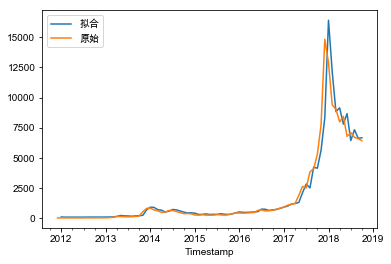

In [258]:
# 原始数据拟合
plt.figure(figsize=(6,4))
model.predict().add(df_month.Weighted_Price.shift(1), fill_value=0).plot(label = '拟合')
df_month.Weighted_Price.plot(label = '原始')
plt.legend()
plt.show()

DW检验 2.0414126020808165


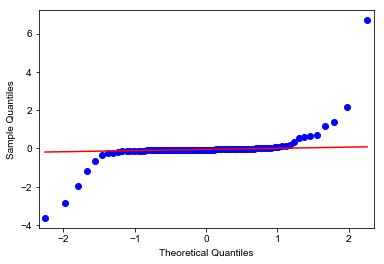

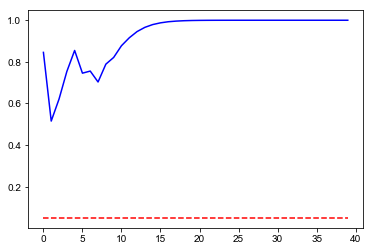

In [187]:
# 白噪声检验
def resid_test(resid):
    fig, ax = plt.subplots(1,1)
    fig = qqplot(resid, line='q', ax=ax, fit=True)

    print("DW检验", sm.stats.durbin_watson(resid.values))
    p_values = acorr_ljungbox(resid, lags=40)[1]
    plt.figure(figsize=(6,4))
    plt.plot(range(40), p_values, '-', color='b')
    plt.plot(range(40), np.ones(40)*0.05, '--', color='r')

resid_test(model.resid)
# 通过检验

In [260]:
# 模型评估 计算RMSE
def RMSE(predict, original):
    ts = predict[~predict.isnull()]
    data = original[ts.index]
    return np.sqrt(sum((ts-data)**2)/ts.size)

RMSE(model.predict().add(df_month.Weighted_Price.shift(1), fill_value=0), df_month.Weighted_Price)

973.379963067414

In [293]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.Weighted_Price   No. Observations:                   82
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -680.604
Method:                       css-mle   S.D. of innovations            973.378
Date:                Mon, 15 Feb 2021   AIC                           1367.207
Time:                        13:08:41   BIC                           1374.427
Sample:                    01-31-2012   HQIC                          1370.106
                         - 10-31-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     77.2260    131.973      0.585      0.560    -181.436     335.888
ma.L1.D.Weighted_Price     0.2305      0.117      1.975      0.052       0.002       0.459
    

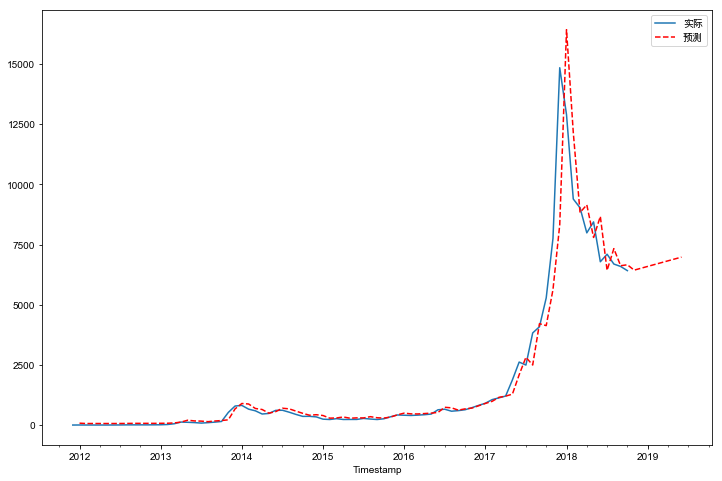

In [332]:
df_month_fit = pd.DataFrame(model.predict().add(df_month.Weighted_Price.shift(1), fill_value=0), columns=['Weighted_Price'])
date_list = pd.date_range('2018-11-01', '2019-07-01',freq='M')
df_month_forecast = pd.DataFrame(data = model.forecast(date_list.size)[0], index = date_list, columns=['Weighted_Price'])
df_month_forecast = pd.concat([df_month_fit, df_month_forecast])

plt.figure(figsize=(12,8))
df_month.Weighted_Price.plot(label = '实际')
df_month_forecast.Weighted_Price.plot(ls='--', color='r', label = '预测')
plt.legend()
plt.show()

## 2.2 用ARMA

In [309]:
# 选用ARMA(0,1)拟合差分后数据
data_arma = df_month.Weighted_Price.diff(1).dropna()
arma = ARMA(data_arma,order=(0,1)).fit()

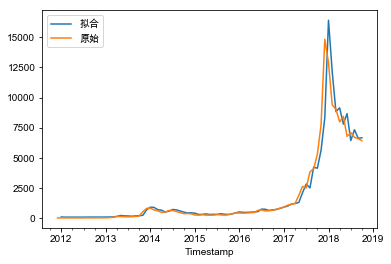

In [316]:
# 原始数据拟合
plt.figure(figsize=(6,4))
arma.predict().add(df_month.Weighted_Price.shift(1), fill_value=0).plot(label='拟合')
df_month.Weighted_Price.plot(label='原始')
plt.legend()
plt.show()

DW检验 2.0414126020808165


973.379963067414

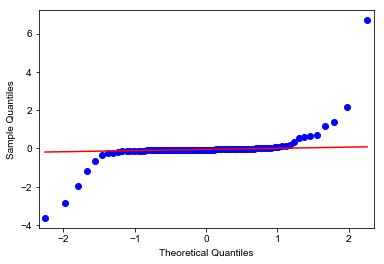

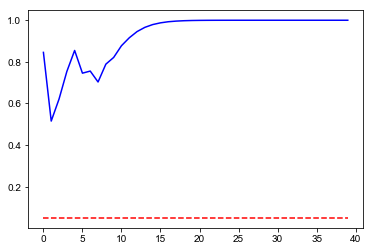

In [319]:
resid_test(arma.resid)
RMSE(arma.predict().add(df_month.Weighted_Price.shift(1), fill_value=0), df_month.Weighted_Price)

In [321]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         Weighted_Price   No. Observations:                   82
Model:                     ARMA(0, 1)   Log Likelihood                -680.604
Method:                       css-mle   S.D. of innovations            973.378
Date:                Mon, 15 Feb 2021   AIC                           1367.207
Time:                        13:20:10   BIC                           1374.427
Sample:                    01-31-2012   HQIC                          1370.106
                         - 10-31-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   77.2260    131.973      0.585      0.560    -181.436     335.888
ma.L1.Weighted_Price     0.2305      0.117      1.975      0.052       0.002       0.459
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -4.3376           +0.0000j            4.3376            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
# 预测值还原
arma.

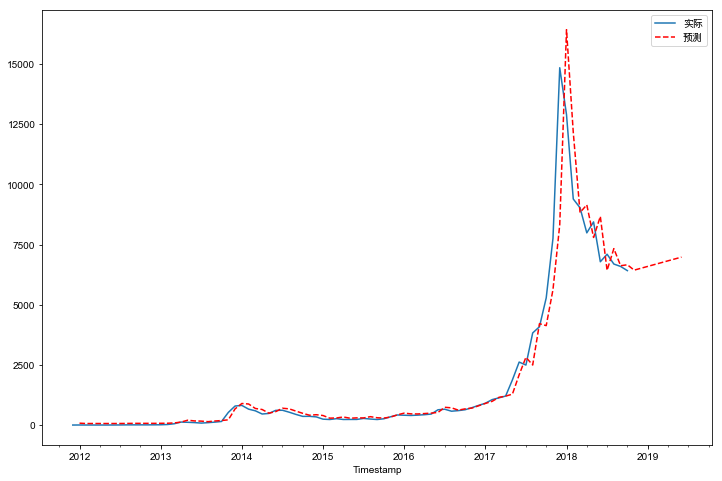

In [333]:
df_month_fit_arma = pd.DataFrame(arma.predict().add(df_month.Weighted_Price.shift(1), fill_value=0), columns=['Weighted_Price'])
df_month_forecast_arma = pd.DataFrame(data = arma.forecast(date_list.size)[0], index = date_list, columns=['Weighted_Price'])
df_month_forecast_arma = pd.concat([df_month[-1:], df_month_forecast_arma]).cumsum()[1:]
df_month_forecast_arma = pd.concat([df_month_fit_arma, df_month_forecast_arma])

plt.figure(figsize=(12,8))
df_month.Weighted_Price.plot(label = '实际')
df_month_forecast_arma.Weighted_Price.plot(ls='--', color='r', label = '预测')
plt.legend()
plt.show()

- 其实两种方法是同样的，只是传入的数据不同，且最后预测值的处理不同